## Analyzing the relationship between Co2 concentrations and temperature changes

### Import required library

In [19]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go 
import plotly.express as px
from scipy.stats import linregress
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from IPython.display import Image


### Import the dataset

In [4]:
temperature_data = pd.read_csv('temperature.csv')
carbon_data = pd.read_csv('carbon_emmission.csv')

In [5]:
temperature_data.head()

,ObjectId,Country,ISO2,ISO3,F1961,F1962,F1963,F1964,F1965,F1966,...,F2013,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022
0,1,"Afghanistan, Islamic Rep. of",AF,AFG,-0.113,-0.164,0.847,-0.764,-0.244,0.226,...,1.281,0.456,1.093,1.555,1.540,1.544,0.910,0.498,1.327,2.012
1,2,Albania,AL,ALB,0.627,0.326,0.075,-0.166,-0.388,0.559,...,1.333,1.198,1.569,1.464,1.121,2.028,1.675,1.498,1.536,1.518
2,3,Algeria,DZ,DZA,0.164,0.114,0.077,0.250,-0.100,0.433,...,1.192,1.690,1.121,1.757,1.512,1.210,1.115,1.926,2.330,1.688
3,4,American Samoa,AS,ASM,0.079,-0.042,0.169,-0.140,-0.562,0.181,...,1.257,1.170,1.009,1.539,1.435,1.189,1.539,1.430,1.268,1.256
4,5,"Andorra, Principality of",AD,AND,0.736,0.112,-0.752,0.308,-0.490,0.415,...,0.831,1.946,1.690,1.990,1.925,1.919,1.964,2.562,1.533,3.243


In [6]:
carbon_data.head()

,ObjectId,Country,Date,Value
0,1,World,1958M03,315.70
1,2,World,1958M04,317.45
2,3,World,1958M05,317.51
3,4,World,1958M06,317.24
4,5,World,1958M07,315.86


### Calculate statistics for temperature changes and Co2 concentrations

In [7]:
# Selecting and computing statistics for temperature changes
temperature_value = temperature_data.filter(regex='^F').stack()
temperature_stats = {
    "Mean" : temperature_value.mean(),
    "Median" : temperature_value.median(),
    "Variance" : temperature_value.var()
}

In [8]:
# Computing statistics for Co2 concentrations
carbon_value = carbon_data["Value"]
carbon_stats = {
    "Mean" : carbon_value.mean(),
    "Median" : carbon_value.median(),
    "Variance" : carbon_value.var()
}

In [9]:
print(temperature_stats)

{'Mean': 0.5377713483146068, 'Median': 0.47, 'Variance': 0.4294524831504413}


In [10]:
print(carbon_stats)

{'Mean': 180.71615286624203, 'Median': 313.835, 'Variance': 32600.002004693}


The average temperature change is around 0.54°C, with a median of 0.47°C and a variance of 0.43, suggesting relatively minor fluctuations in temperature anomalies.

In contrast, CO₂ concentrations have a mean of 180.72 ppm, a notably higher median of 313.84 ppm, and a variance of 32,600, indicating significant variability in CO₂ levels throughout the dataset's period.

### Time-Sries Analysis

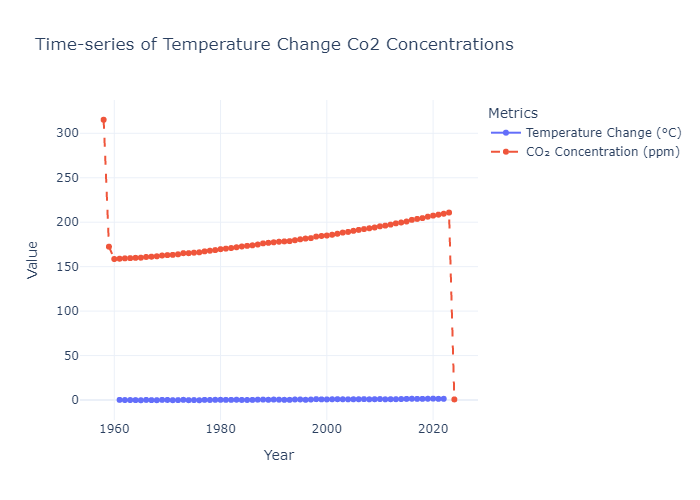

In [24]:
# Extracting time-series data for plotting
temperature_year = temperature_data.filter(regex='^F').mean(axis=0)
temperature_year.index = temperature_year.index.str.replace('F','').astype(int)

# 
carbon_data['Year'] = carbon_data['Date'].str[:4].astype(int)
carbon_year = carbon_data.groupby('Year')['Value'].mean()

figure = go.Figure()
figure.add_trace(go.Scatter(
    x=temperature_year.index, y=temperature_year.values,
    mode='lines+markers', name="Temperature Change (°C)"
))
figure.add_trace(go.Scatter(
    x=carbon_year.index, y=carbon_year.values,
    mode='lines+markers', name="CO₂ Concentration (ppm)", line=dict(dash='dash')
))
figure.update_layout(
    title = 'Time-series of Temperature Change Co2 Concentrations',
    xaxis_title = 'Year',
    yaxis_title = "Value",
    template = 'plotly_white',
    legend_title = 'Metrics'
)
figure.show()
figure.write_image('time_series.png')
Image('time_series.png')


The time-series graph illustrates a steady rise in CO₂ concentrations over the years. Alongside this, a gradual increase in global temperature change suggests a link between higher CO₂ levels and global warming.

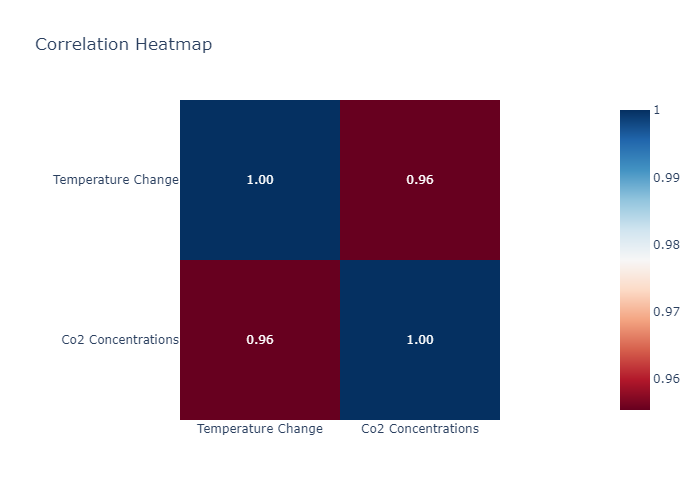

In [23]:
# Correlation heatmap
merged_data = pd.DataFrame({
    "Temperature Change": temperature_year,
    "Co2 Concentrations": carbon_year
}).dropna()

heatmap = px.imshow(
    merged_data.corr(),
    text_auto = ".2f",
    color_continuous_scale = "RdBu",
    title = "Correlation Heatmap"
)
heatmap.update_layout(template = "plotly_white")
heatmap.show()
heatmap.write_image('heatmap.png')
Image('heatmap.png')

The heatmap indicates a strong positive correlation of 0.96 between CO₂ concentrations and temperature changes. This statistical connection underscores the close association between rising CO₂ levels and increasing global temperatures.

### Analzing season variations

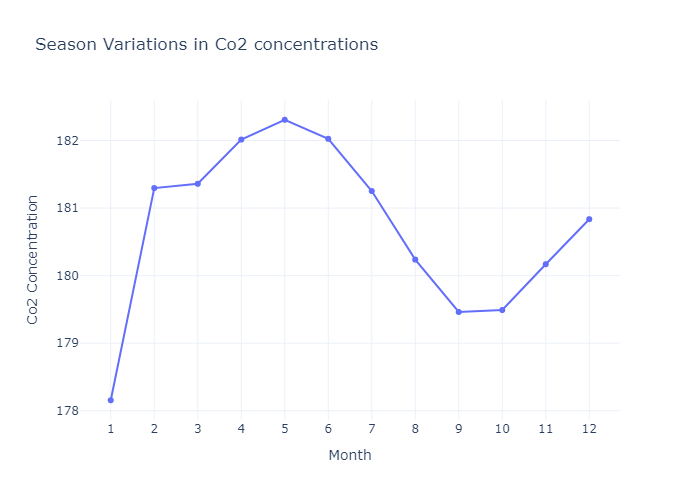

In [25]:
carbon_data['Month'] = carbon_data['Date'].str[-2:].astype(int)
carbon_month = carbon_data.groupby('Month')['Value'].mean()

figures_season = px.line(
    carbon_month,
    x = carbon_month.index,
    y = carbon_month.values,
    labels = {'x': 'Month', 'y': 'Co2 Concentration'},
    title = 'Season Variations in Co2 concentrations',
    markers = True
)
figures_season.update_layout(
    xaxis = dict(tickmode = 'array', tickvals = list(range(1,13))),
    template = 'plotly_white'
)
figures_season.show()
figures_season.write_image('season_variation.png')
Image('season_variation.png')

The graph highlights seasonal variations in CO₂ concentrations, with levels peaking in late spring and early summer (around May) and dropping to their lowest in the fall (around September).

These fluctuations are likely driven by natural processes, such as plant photosynthesis, which removes CO₂ during the growing season, and respiration, which releases CO₂ during the off-season.

### Clustering Climate Patters

In [14]:
clustering_data = merged_data[['Temperature Change', 'Co2 Concentrations']].dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

k_means = KMeans(n_clusters=3, random_state=42)
clustering_data['Cluster'] = k_means.fit_predict(scaled_data)

clustering_data['Label'] = clustering_data['Cluster'].map({
    0: 'Moderate Temperature and Co2',
    1: 'High Temperature and C02',
    2: 'Low Temperature and Co2'
})

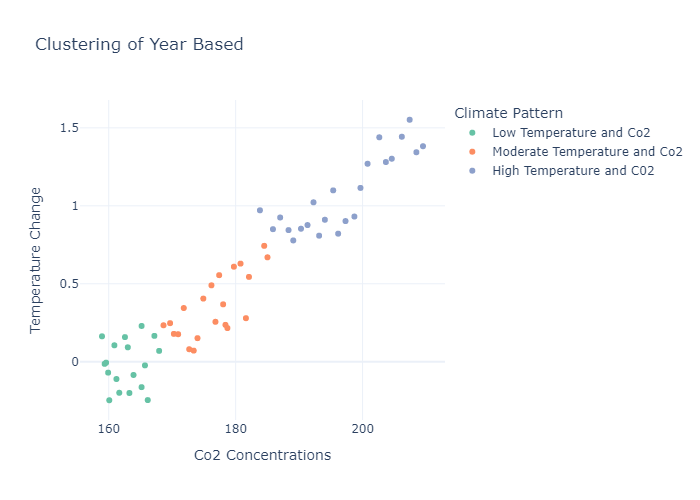

In [26]:
figure_cluster = px.scatter(
    clustering_data,
    x = 'Co2 Concentrations',
    y = 'Temperature Change',
    color = 'Label',
    color_discrete_sequence = px.colors.qualitative.Set2,
    labels = {
        'Co2 Concentration': 'Co2 Concentration',
        'Temperature Change': 'Temperature Change',
        'Label': 'Climate Pattern'
    },
    title = 'Clustering of Year Based'
)

figure_cluster.update_layout(
    template = 'plotly_white',
    legend_title = 'Climate Pattern'
)

figure_cluster.show()
figure_cluster.write_image('cluster.png')
Image('cluster.png')

The clustering graph categorizes years into three distinct climate patterns based on CO₂ levels and temperature changes: low CO₂ and temperature (green), moderate CO₂ and temperature (orange), and high CO₂ and temperature (blue). The transition from green to orange to blue clusters demonstrates a clear trend of rising temperatures alongside increasing CO₂ levels, effectively highlighting the relationship between greenhouse gas concentrations and global temperature changes.

### Predict temperature changes 

In [16]:
X = merged_data[['Co2 Concentrations']].values
y = merged_data['Temperature Change'].values

model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [17]:
def simulate_temperature_change(co2_percentage_change):
    curr_mean_co2 = merged_data['Co2 Concentrations'].mean()
    new_co2 = curr_mean_co2 * (1 + co2_percentage_change/100)

    # predict temperature change
    prediction = model.predict([[new_co2]])
    return prediction

In [18]:
temperature_change = {
    'increase co2 10%': simulate_temperature_change(10),
    'decrease co2 10%': simulate_temperature_change(-10),
    'increase co2 20%': simulate_temperature_change(20),
    'decrease co2 20%': simulate_temperature_change(-20)
}

temperature_change

{'increase co2 10%': array([1.0866445]),
 'decrease co2 10%': array([-0.05999304]),
 'increase co2 20%': array([1.65996328]),
 'decrease co2 20%': array([-0.63331181])}

An increase of 10% in CO₂ leads to a noticeable rise in temperature anomalies, highlighting the strong sensitivity of global temperatures to CO₂ levels. On the other hand, reducing CO₂ by 10-20% could result in substantial cooling effects, potentially mitigating some of the ongoing warming trends.